In [41]:
import jax, jax.numpy as jnp
import optax
from prior import periodic_kernel

jax.config.update("jax_enable_x64", True)

In [55]:
X = jnp.linspace(0, 10, 100)
Y = jnp.sin(X)
K = periodic_kernel(X, X, period=1.0, lengthscale=1.0) + jnp.eye(len(X)) * 1e-6

In [61]:
def loss_fn(alpha):
    preds = alpha.T @ jax.scipy.linalg.solve(K, alpha, assume_a="sym")
    return jnp.mean((preds -Y)**2)    # e.g. MSE

alpha = jnp.ones_like(Y) 
lr = 1e-2

for step in range(100):
    grads = jax.grad(loss_fn)(alpha) 
    pre_grads = K @ grads                  # apply kernel preconditioner
    alpha = alpha - lr * pre_grads 

In [58]:
optimizer = optax.adam(learning_rate=1e-4)
opt_state = optimizer.init(alpha)

@jax.jit
def update(alpha, opt_state):
    grads = jax.grad(loss_fn)(alpha)        # ∇_α L
    grads = K @ grads           # precondition
    updates, opt_state = optimizer.update(grads, opt_state, alpha)
    return optax.apply_updates(alpha, updates), opt_state

for step in range(100):
    alpha, opt_state = update(alpha, opt_state)

In [60]:
@jax.jit
def train_step(alpha, opt_state, X, y, K):
    # 1. compute MSE loss + grads
    preds = K @ alpha
    loss = jnp.mean((preds - y)**2)
    grads = jax.grad(lambda a: jnp.mean((K @ a - y)**2))(alpha)
    # 2. kernel precondition
    grads = K @ grads
    # 3. Adam update
    updates, opt_state = optimizer.update(grads, opt_state, alpha)
    alpha = optax.apply_updates(alpha, updates)
    return alpha, opt_state, loss

epochs = 1000
for epoch in range(epochs):
    alpha, opt_state, loss = train_step(alpha, opt_state, X, Y, K)
    if epoch % 100 == 0:
        print(f"epoch {epoch}, loss {loss:.4f}")


epoch 0, loss 1956.2611
epoch 100, loss 1847.9257
epoch 200, loss 1752.8724
epoch 300, loss 1665.1473
epoch 400, loss 1582.6566
epoch 500, loss 1504.3841
epoch 600, loss 1429.7417
epoch 700, loss 1358.3467
epoch 800, loss 1289.9286
epoch 900, loss 1224.2839


In [66]:
from jax.example_libraries.optimizers import adam

In [67]:
import jax.example_libraries
import jax, jax.numpy as jnp
from functools import partial

# 1) Toy dataset: 10 points in [-2,2]
key = jax.random.PRNGKey(0)
x_train = jnp.linspace(-2, 2, 10)
y_train = jnp.sin(2 * jnp.pi * x_train)

# 2) Simple 1-hidden‐layer MLP
def init_params(key, hidden=16):
    k1, k2 = jax.random.split(key)
    W1 = jax.random.normal(k1, (1, hidden)) * 0.1
    b1 = jnp.zeros((hidden,))
    W2 = jax.random.normal(k2, (hidden, 1)) * 0.1
    b2 = jnp.zeros((1,))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

def f(params, x):
    x = x[:, None]                       # [n,1]
    h = jnp.tanh(x @ params['W1'] + params['b1'])  # [n,hidden]
    y = h @ params['W2'] + params['b2']            # [n,1]
    return y.ravel()                     # [n]

# 3) Periodic kernel Gram on the same grid
def periodic_kernel(x, y, period=1., ℓ=0.5):
    diff = x[:, None] - y[None, :]
    return jnp.exp(-2/ℓ**2 * jnp.sin(jnp.pi * diff/period)**2)

K = periodic_kernel(x_train, x_train)

# 4) Loss on data
def data_loss(params):
    preds = f(params, x_train)
    return jnp.mean((preds - y_train)**2)

# 5) One ordinary Adam step vs one preconditioned step
lr = 1e-2
opt = adam(lr)
opt_init, opt_update, get_params = opt

# (a) Standard grad‐step
params0 = init_params(key)
opt_state_std = opt_init(params0)
grads = jax.grad(data_loss)(get_params(opt_state_std))
opt_state_std = opt_update(0, grads, opt_state_std)
params_std = get_params(opt_state_std)
loss_std = data_loss(params_std)

# (b) Kernel‐preconditioned step via VJP
params1 = init_params(key)
opt_state_pre = opt_init(params1)

# 1) get VJP for f(·, x_train)
y0, vjp_fun = jax.vjp(partial(f, x=x_train), params1)

# 2) compute data‐loss cotangent in output‐space
dL_df = 2 * (y0 - y_train) / y_train.size    # ∂/∂y MSE

# 3) precondition in function‐space
dL_df_tilde = K @ dL_df

# 4) pull back into param‐space
delta_params = vjp_fun(dL_df_tilde)[0]

# 5) apply Adam‐style update (but with our pre‐grad)
opt_state_pre = opt_update(0, delta_params, opt_state_pre)
params_pre = get_params(opt_state_pre)
loss_pre = data_loss(params_pre)

print(f"Loss after one standard Adam step:      {loss_std:.4f}")
print(f"Loss after one kernel‐preconditioned step: {loss_pre:.4f}")

Loss after one standard Adam step:      0.4498
Loss after one kernel‐preconditioned step: 0.4508


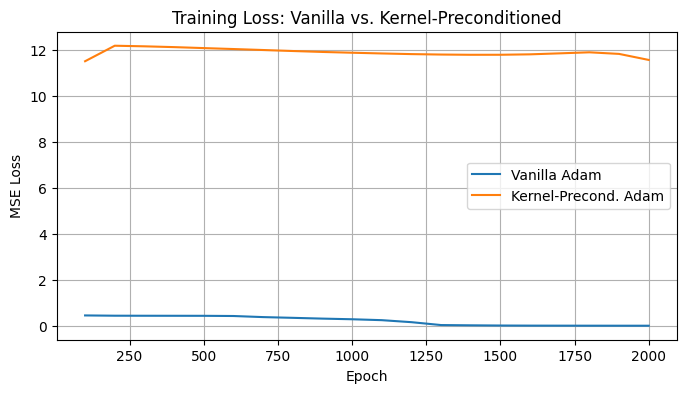

In [82]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from functools import partial
import matplotlib.pyplot as plt

# 1) Create noisy sinusoidal data
key = jax.random.PRNGKey(0)
n = 100
x = jnp.linspace(-2, 2, n)
y_true = jnp.sin(2 * jnp.pi * x)
noise = 0.1 * jax.random.normal(key, (n,))
y = y_true + noise

# 2) Define a small tanh MLP
def init_mlp_params(key, widths):
    params = []
    keys = jax.random.split(key, len(widths))
    for k, (in_w, out_w) in zip(keys, zip(widths[:-1], widths[1:])):
        W = jax.random.normal(k, (in_w, out_w)) * jnp.sqrt(2/(in_w+out_w))
        b = jnp.zeros((out_w,))
        params.append({'W': W, 'b': b})
    return params

def mlp_apply(params, x):
    h = x[:, None]
    for layer in params[:-1]:
        h = jnp.tanh(h @ layer['W'] + layer['b'])
    # final layer linear
    out = h @ params[-1]['W'] + params[-1]['b']
    return out.ravel()

# 3) Build periodic kernel Gram on training inputs
def periodic_kernel(x, y, period=1.0, lengthscale=0.5):
    diff = x[:, None] - y[None, :]
    return jnp.exp(-2/lengthscale**2 * jnp.sin(jnp.pi * diff/period)**2)

jitter = 1e-3
K_reg = K + jitter * np.eye(n)
K = jax.lax.stop_gradient(K)  # ensure no gradients through K

# 4) Define loss and optimizer
def loss_fn(params):
    preds = mlp_apply(params, x)
    return jnp.mean((preds - y) ** 2)#jax.scipy.stats.norm.logpdf(preds, y, 0.1).mean() #((preds - y)**2)

optimizer = optax.adam(1e-3)

# 5) Initialize
widths = [1, 32, 32, 1]
params_vanilla = init_mlp_params(key, widths)
params_pre = init_mlp_params(key, widths)
opt_state_v = optimizer.init(params_vanilla)
opt_state_p = optimizer.init(params_pre)

# 6) Training settings
epochs = 2000
record_every = 100
losses_v = []
losses_p = []

# 7) Training loops
for epoch in range(1, epochs + 1):
    # Vanilla step
    grads_v = jax.grad(loss_fn)(params_vanilla)
    updates_v, opt_state_v = optimizer.update(grads_v, opt_state_v)
    params_vanilla = optax.apply_updates(params_vanilla, updates_v)
    
    # Preconditioned step via VJP
    # 1) compute output and VJP function on grid x
    y_pred, vjp_fun = jax.vjp(lambda p: mlp_apply(p, x), params_pre)
    # 2) data-space cotangent
    cot = 2 * (y_pred - y) / n
    cot = 2 * (y_pred - y) / n
    # add ridge -> adds λ * K^{-1} α term
    ridge_term = 0.001 * np.linalg.solve(K + jitter * jnp.eye(n), alpha)
    cot_tilde = K @ cot + ridge_term
    # 3) apply kernel preconditioner in function-space
    cot_tilde = K @ cot
    # 4) pull back to param-space
    pre_grads = vjp_fun(cot_tilde)[0]
    updates_p, opt_state_p = optimizer.update(pre_grads, opt_state_p)
    params_pre = optax.apply_updates(params_pre, updates_p)
    
    # record losses
    if epoch % record_every == 0:
        losses_v.append(loss_fn(params_vanilla))
        losses_p.append(loss_fn(params_pre))

# 8) Plot losses
plt.figure(figsize=(8, 4))
steps = np.arange(record_every, epochs+1, record_every)
plt.plot(steps, losses_v, label='Vanilla Adam')
plt.plot(steps, losses_p, label='Kernel-Precond. Adam')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss: Vanilla vs. Kernel-Preconditioned')
plt.legend()
plt.grid(True)
plt.show()


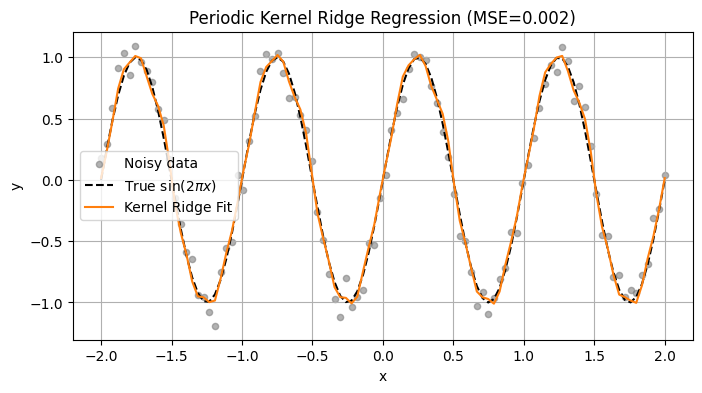

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Generate noisy sinusoidal data
np.random.seed(0)
m = 100
x = np.linspace(-2, 2, m)
y_true = np.sin(2 * np.pi * x)
y_noisy = y_true + 0.1 * np.random.randn(m)

# 2) Define periodic kernel
def periodic_kernel(x, y, period=1.0, lengthscale=0.5):
    diff = x[:, None] - y[None, :]
    return np.exp(-2 / lengthscale**2 * np.sin(np.pi * diff / period)**2)

# 3) Build Gram matrix and add jitter for stability
K = periodic_kernel(x, x)
jitter = 1e-3
K_reg = K + jitter * np.eye(m)

# 4) Kernel ridge regression: α = (K + λI)^{-1} y
lam = 1e-2
alpha = np.linalg.solve(K_reg + lam * np.eye(m), y_noisy)

# 5) Predictions on training domain
preds_ridge = K @ alpha

# 6) Compute MSE against true function
mse_ridge = np.mean((preds_ridge - y_true)**2)

# 7) Plot data, true function, and kernel-ridge prediction
plt.figure(figsize=(8, 4))
plt.scatter(x, y_noisy, color='gray', alpha=0.6, s=20, label='Noisy data')
plt.plot(x, y_true, 'k--', label='True $\\sin(2\\pi x)$')
plt.plot(x, preds_ridge, 'C1', label='Kernel Ridge Fit')
plt.title(f'Periodic Kernel Ridge Regression (MSE={mse_ridge:.3f})')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


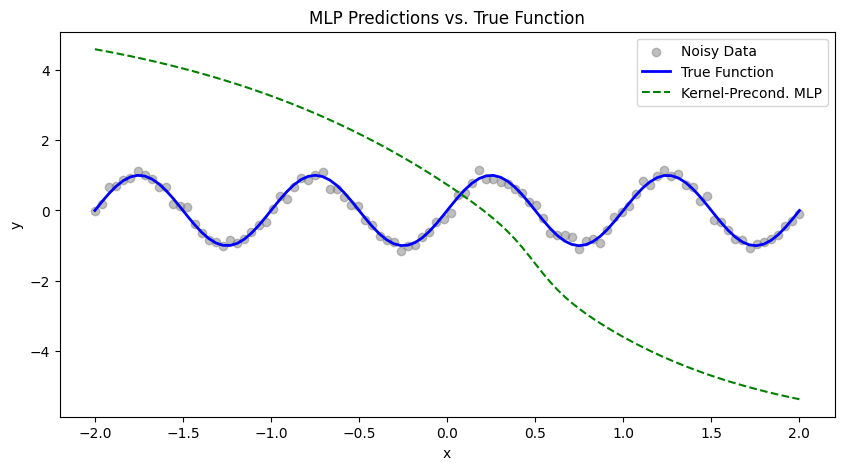

In [83]:
# plot the predictions
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='Noisy Data', color='gray', alpha=0.5)
plt.plot(x, y_true, label='True Function', color='blue', linewidth=2)
#plt.plot(x, mlp_apply(params_vanilla, x), label='Vanilla MLP', color='orange', linestyle='--')
plt.plot(x, mlp_apply(params_pre, x), label='Kernel-Precond. MLP', color='green', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('MLP Predictions vs. True Function')
plt.legend()